In [22]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [20]:
#### Read the Data
###### Link: https://archive.ics.uci.edu/static/public/45/heart+disease.zip
filename = "processed.cleveland.data"
feature_dictionary = {
    "age": "Age of a candidate",
    "sex": "Sex of a candidate",
    "cp": "chest pain",
    "restbp": "resting blood pressure (in mm Hg)",
    "chol": "serum cholestrol in (mg/dl)",
    "fbs": "fasting blood sugar",
    "restecg": "resting electrocardographic results",
    "thalach": "maximum heart rate achieved",
    "exang": "exercise induced agnia",
    "oldpeak": "ST depression induced by exercise relative to rest",
    "slope": "the slope of the peak exercise ST segment",
    "ca": "number of major vessels(0-3) colored by fluoroscopy",
    "thal": "this is short of thallium heart scan",
    "hd": "diagnosis of heart disease, the predicted attribute"
}
headers = list(feature_dictionary.keys())
df = pd.read_csv(
    filename,
    header=None
)

df.columns = headers
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


##### EDA

In [24]:
# Number of rows and column of data, and check for duplicates in the data
df.shape, df.drop_duplicates().shape

((303, 14), (303, 14))

In [25]:
# Check for data types of each columns
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

In [37]:
# Check for Nulls in each columns
df.isna().sum()

age        0
sex        0
cp         0
restbp     0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         0
thal       0
hd         0
dtype: int64

In [38]:
# Check for empty string in any columns
df.eq("").sum()

age        0
sex        0
cp         0
restbp     0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         0
thal       0
hd         0
dtype: int64

In [45]:
# Since the data type of "thal" and "ca" is object
# object: (Generally when we have mixed datatypes present in a column, object datatype gets assigned to it)

# Let's check unique values in "thal" and "ca"
df["thal"].value_counts(normalize=True), df["ca"].value_counts(normalize=True)

(thal
 3.0    0.547855
 7.0    0.386139
 6.0    0.059406
 ?      0.006601
 Name: proportion, dtype: float64,
 ca
 0.0    0.580858
 1.0    0.214521
 2.0    0.125413
 3.0    0.066007
 ?      0.013201
 Name: proportion, dtype: float64)

#### Imputing the missing values

In [60]:
# Now that, we have missing values in two columns namely "ca" and "thal"
# We need use a suitable imputer for them

# Lets what percent of data is missing
df.value_counts(["ca", "thal"], normalize=True).reset_index().query("(ca == '?') | (thal == '?')")

# We can see, there is roughly 2% of data has missing values
# There is no harm in dropping these datasets

,ca,thal,proportion
11,0.0,?,0.006601
13,?,3.0,0.006601
14,?,7.0,0.006601


In [64]:
# Filter the data after removing missing values from "ca" and "thal"
df_no_missing = df.query(
    "(ca != '?') & (thal != '?')"
).reset_index(drop=True)
df_no_missing.shape

(297, 14)

#### Split the data to make classification tree

In [70]:
# Check the dtypes of data
df_no_missing.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

In [72]:
# Get the columns for X and y
X = df_no_missing.select_dtypes(exclude='int') # Because Integer datatype is used for Y variable
y = df_no_missing.select_dtypes(include='int')

In [74]:
X.shape, y.shape

((297, 13), (297, 1))

#### Encoding of categorical data

In [76]:
# On analyzing a categorical feature "cp", we oberve it has 4 values
# 1: typical angina
# 2: atypical angina
# 3: Non anginal pain
# 4: asymptomatic

# If we treat this categories as it is, the model is going to assume
# Category 4 is similar to Category 3 than to Category 1 and 2
X['cp'].value_counts()

cp
4.0    142
3.0     83
2.0     49
1.0     23
Name: count, dtype: int64

In [92]:
# We will perform one hot encoding on the categorical dataframes
cols_to_encode = [
    "cp", "restecg", "slope", "thal"
]
X_encoded = pd.get_dummies(
    X, columns=cols_to_encode
)
X_encoded.head()


,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,False,True,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,True,False,False,True,False,True,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,True,False,False,True,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,False,True,False,False,False,False,True,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,False,True,True,False,False,True,False,False


In [90]:
# Process y such that it contains only two categories 0 and 1
print(f"Unique values present in y: {y["hd"].unique()}")

y.loc[y["hd"] > 0, ['hd']] = 1

print(f"Unique values present in y after processing: {y["hd"].unique()}")
y.value_counts()

Unique values present in y: [0 1]
Unique values present in y after processing: [0 1]


hd
0     160
1     137
Name: count, dtype: int64

#### Build a premliminary Classification Tree

In [95]:
# Split the data into Test and Train
seed_for_random_numbers = 42
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, random_state=seed_for_random_numbers
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((222, 22), (222, 1), (75, 22), (75, 1))

In [150]:
# Parameters for DecisionTreeClassifier
clf_dt_params = {
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': seed_for_random_numbers,
 'splitter': 'best'
 }

# Create a base Decision Tree
clf_dt = DecisionTreeClassifier(**clf_dt_params)
clf_dt = clf_dt.fit(X_train, y_train)

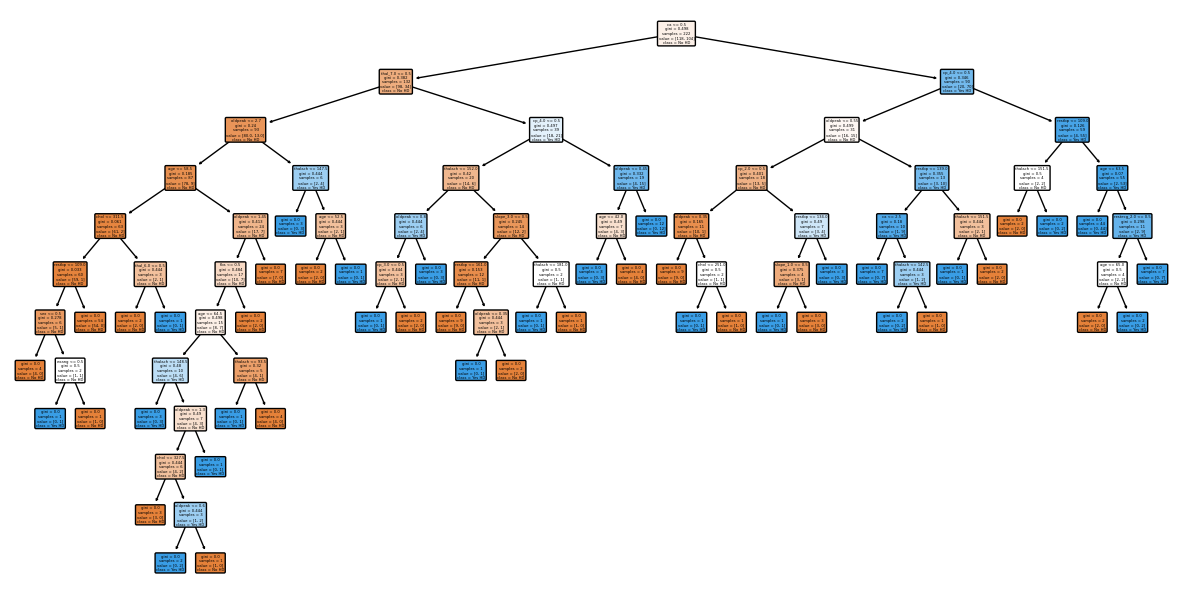

In [151]:
# Plot the Decision Tree
plt.figure(figsize=(15, 7.5))
plot_tree(
    clf_dt,
    filled=True,
    rounded=True,
    class_names=["No HD", "Yes HD"],
    feature_names=X_encoded.columns
)
plt.show()

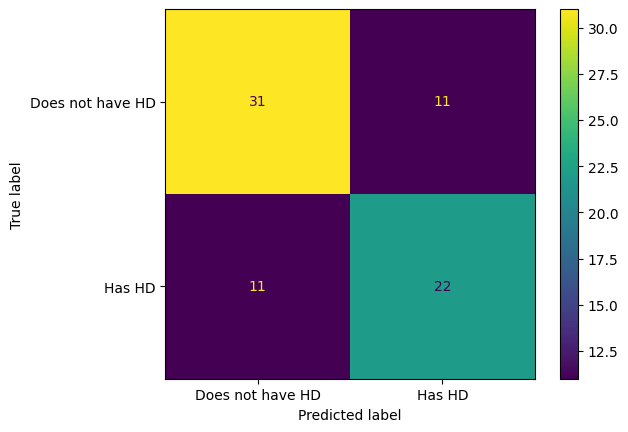

In [126]:
# Measure the performance of this tree on testing datasets
y_test_pred = clf_dt.predict(X_test)
test_confusion_matrix = confusion_matrix(
    y_test, y_test_pred, labels=clf_dt.classes_
)

ConfusionMatrixDisplay(
    test_confusion_matrix,
    display_labels=["Does not have HD", "Has HD"]
).plot()